### https://amazon-berkeley-objects.s3.amazonaws.com/index.html

In [1]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
# !wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-original.tar

--2024-10-21 05:09:48--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 54.231.230.145, 3.5.30.73, 54.231.201.161, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|54.231.230.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253381120 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

abo-images-small.ta 100%[===================>]   3.03G  15.8MB/s    in 3m 37s  

2024-10-21 05:13:26 (14.3 MB/s) - ‘abo-images-small.tar’ saved [3253381120/3253381120]



In [2]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar

--2024-10-21 05:13:26--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.217.170.121, 52.216.214.209, 16.15.192.141, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.217.170.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87480320 (83M) [application/x-tar]
Saving to: ‘abo-listings.tar’

abo-listings.tar    100%[===================>]  83.43M  12.3MB/s    in 19s     

2024-10-21 05:13:46 (4.36 MB/s) - ‘abo-listings.tar’ saved [87480320/87480320]



In [3]:
import shutil
shutil.unpack_archive("/content/abo-images-small.tar", "/content/abo-images-small")

shutil.unpack_archive("/content/abo-listings.tar", "/content/abo-listings")

In [4]:
ls /content/abo-listings/listings/metadata/

listings_0.json.gz  listings_4.json.gz  listings_8.json.gz  listings_c.json.gz
listings_1.json.gz  listings_5.json.gz  listings_9.json.gz  listings_d.json.gz
listings_2.json.gz  listings_6.json.gz  listings_a.json.gz  listings_e.json.gz
listings_3.json.gz  listings_7.json.gz  listings_b.json.gz  listings_f.json.gz


In [5]:
import os
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt

# Path to the folder containing your .json.gz files
folder_path = '/content/abo-listings/listings/metadata'
data_dict = dict()
# Iterate through all the files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.json.gz'):  # Check if the file is a .json.gz file
        file_path = os.path.join(folder_path, file_name)

        # Open and read the gzipped JSON file line by line
        with gzip.open(file_path, 'rt', encoding='utf-8') as gz_file:
            print(f"Reading file: {file_name}")
            for idx , line in enumerate(gz_file):  # Read each line
                try:
                    data = json.loads(line)  # Load each line as a separate JSON object
                    for item_name in data['item_name'] :
                      if('en_' in item_name['language_tag']) :
                        data_dict[f"{file_name}_{idx}"] = dict()
                        data_dict[f"{file_name}_{idx}"]["product_name"] = item_name['value']
                        data_dict[f"{file_name}_{idx}"]["hierarchy"] = data.get('node',None)
                        all_image_id = [data.get('main_image_id',None)]
                        if data.get('other_image_id',None) :
                          pass
                          # all_image_id.extend(data.get('other_image_id',None))
                        data_dict[f"{file_name}_{idx}"]["image_id"] = all_image_id
                except json.JSONDecodeError as e:
                    print(f"Could not parse JSON in file {file_name}: {e}")

Reading file: listings_b.json.gz
Reading file: listings_8.json.gz
Reading file: listings_7.json.gz
Reading file: listings_d.json.gz
Reading file: listings_5.json.gz
Reading file: listings_4.json.gz
Reading file: listings_3.json.gz
Reading file: listings_1.json.gz
Reading file: listings_2.json.gz
Reading file: listings_f.json.gz
Reading file: listings_9.json.gz
Reading file: listings_6.json.gz
Reading file: listings_c.json.gz
Reading file: listings_e.json.gz
Reading file: listings_0.json.gz
Reading file: listings_a.json.gz


In [6]:
all_data = []
for key in data_dict.keys() :
  d = data_dict[key]
  d['key'] = key
  all_data.append(d)

ecomm_data = pd.DataFrame((all_data))
ecomm_data = ecomm_data.explode('image_id')
ecomm_data = ecomm_data.dropna()
ecomm_data.drop(columns = ['key'],inplace = True)
ecomm_data["clean_hierarchy"] = ecomm_data.hierarchy.apply(lambda x : x[-1]['node_name'])
ecomm_data = ecomm_data.dropna()
ecomm_data = ecomm_data[ecomm_data.clean_hierarchy.str.find('カテゴリー別') == -1]
ecomm_data["target_class"] = ecomm_data.clean_hierarchy.apply(lambda text :  text.split("/")[-2])
ecomm_data = ecomm_data[ecomm_data['target_class'] != ""]

ecomm_data_agg = ecomm_data.groupby('target_class').agg({'target_class':'count'}).rename(columns = {'target_class':'count'}).reset_index()
target_class_list = ecomm_data_agg[ecomm_data_agg['count'] > 222].target_class.unique()

ecomm_data = ecomm_data[ecomm_data.target_class.isin(target_class_list)]

ecomm_data_rest = ecomm_data[ecomm_data.target_class != 'Cases & Covers']
ecomm_data_cc = ecomm_data[ecomm_data.target_class == 'Cases & Covers']

ecomm_data = pd.concat([ecomm_data_rest,ecomm_data_cc.sample(3000)]).reset_index(drop =True)

In [7]:
ecomm_data.target_class.value_counts()

,count
target_class,
Cases & Covers,3000
Shoes,2878
Living Room Furniture,1949
Casual Shoes,1808
Men's Shoes,1753
Women,1364
Categories,946
Mobile Accessories,912
Sports & Outdoor Shoes,885


In [8]:
ecomm_data.head()

,product_name,hierarchy,image_id,clean_hierarchy,target_class
0,CGTL Ear Loops Face Bandana Neck Gaiter Stylis...,"[{'node_id': 10287485011, 'node_name': '/Categ...",51GM3Rpdm8L,/Categories/Women/Accessories/Neck Gaiters,Accessories
1,Amazon Brand - Symbol Men's Casual Shoes,"[{'node_id': 1983577031, 'node_name': '/Catego...",71CGpqbMBQL,/Categories/Shoes/Men's Shoes/Casual Shoes/Sne...,Casual Shoes
2,Amazon Brand - Solimo Designer Leaves Printed ...,"[{'node_id': 1389409031, 'node_name': '/Catego...",71E5baQtWoL,/Categories/Mobiles & Accessories/Mobile Acces...,Mobile Accessories
3,10k White Gold Swiss-Blue-Topaz and Diamond Ac...,"[{'node_id': 7454922011, 'node_name': '/Depart...",71z-EGaFoxL,/Departments/Women/Jewelry/Earrings/Drop & Dangle,Earrings
4,Amazon Brand – Rivet Canton Deep Mid-Century M...,"[{'node_id': 3733551, 'node_name': '/Categorie...",81QgMliAC2L,/Categories/Furniture/Living Room Furniture/So...,Living Room Furniture


In [9]:
ecomm_data.shape

(25037, 5)

In [10]:
ecomm_data.target_class.nunique()

34

In [11]:
image_metadata = pd.read_csv("/content/abo-images-small/images/metadata/images.csv.gz")

In [12]:
ecomm_data_final = pd.merge(ecomm_data,image_metadata[['image_id','path']],on = 'image_id',how = 'inner')

In [13]:
ecomm_data_final.shape

(25037, 6)

In [14]:
ecomm_data_final.isnull().sum()

,0
product_name,0
hierarchy,0
image_id,0
clean_hierarchy,0
target_class,0
path,0


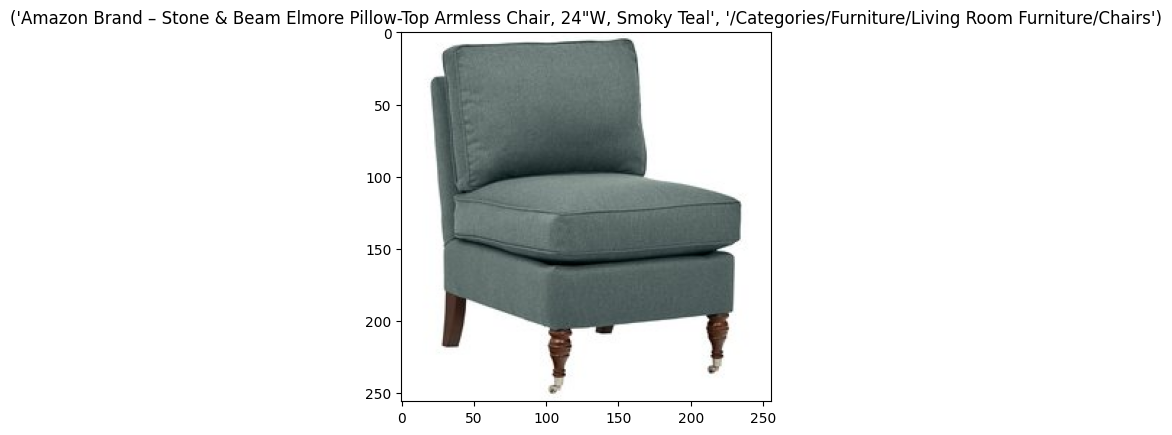

In [15]:
from random import randint
sample_data = ecomm_data_final.to_dict(orient = 'records')[randint(0,len(ecomm_data_final))]

img = plt.imread(f"/content/abo-images-small/images/small/{sample_data['path']}")
plt.title(f"{sample_data['product_name'],sample_data['hierarchy'][-1]['node_name']}")
plt.imshow(img)

In [16]:
sample_data

{'product_name': 'Amazon Brand – Stone & Beam Elmore Pillow-Top Armless Chair, 24"W, Smoky Teal',
 'hierarchy': [{'node_id': 3733491,
   'node_name': '/Categories/Furniture/Living Room Furniture/Chairs'}],
 'image_id': 'A1a6-Ze6tWL',
 'clean_hierarchy': '/Categories/Furniture/Living Room Furniture/Chairs',
 'target_class': 'Living Room Furniture',
 'path': 'cb/cbf00f9b.jpg'}

In [17]:
ecomm_data_final.target_class.value_counts()

,count
target_class,
Cases & Covers,3000
Shoes,2878
Living Room Furniture,1949
Casual Shoes,1808
Men's Shoes,1753
Women,1364
Categories,946
Mobile Accessories,912
Sports & Outdoor Shoes,885


In [18]:
ecomm_data_final.head()

,product_name,hierarchy,image_id,clean_hierarchy,target_class,path
0,CGTL Ear Loops Face Bandana Neck Gaiter Stylis...,"[{'node_id': 10287485011, 'node_name': '/Categ...",51GM3Rpdm8L,/Categories/Women/Accessories/Neck Gaiters,Accessories,b4/b421fb26.jpg
1,Amazon Brand - Symbol Men's Casual Shoes,"[{'node_id': 1983577031, 'node_name': '/Catego...",71CGpqbMBQL,/Categories/Shoes/Men's Shoes/Casual Shoes/Sne...,Casual Shoes,58/58a57f2c.jpg
2,Amazon Brand - Solimo Designer Leaves Printed ...,"[{'node_id': 1389409031, 'node_name': '/Catego...",71E5baQtWoL,/Categories/Mobiles & Accessories/Mobile Acces...,Mobile Accessories,d8/d8743063.jpg
3,10k White Gold Swiss-Blue-Topaz and Diamond Ac...,"[{'node_id': 7454922011, 'node_name': '/Depart...",71z-EGaFoxL,/Departments/Women/Jewelry/Earrings/Drop & Dangle,Earrings,43/43e5efc9.jpg
4,Amazon Brand – Rivet Canton Deep Mid-Century M...,"[{'node_id': 3733551, 'node_name': '/Categorie...",81QgMliAC2L,/Categories/Furniture/Living Room Furniture/So...,Living Room Furniture,1c/1ce4d023.jpg


## Train Test Split

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

strat_column = 'target_class'
train_size = 0.7
val_size = 0.15
test_size = 0.15

label_encoder = LabelEncoder()
ecomm_data_final['label'] = label_encoder.fit_transform(ecomm_data_final[strat_column])

train_data, temp_data = train_test_split(ecomm_data_final,
                                         stratify=ecomm_data_final[strat_column],
                                         test_size=(val_size + test_size),
                                         random_state=42)

val_data, test_data = train_test_split(temp_data,
                                       stratify=temp_data[strat_column],
                                       test_size=test_size/(test_size + val_size),
                                       random_state=42)

train_data['split'] = 'train'
val_data['split'] = 'validation'
test_data['split'] = 'test'

ecomm_data_final = pd.concat([train_data, val_data, test_data])

print(ecomm_data_final['split'].value_counts())  # To see the distribution of the flags


split
train         17525
validation     3756
test           3756
Name: count, dtype: int64


In [20]:
ecomm_data_final.to_csv("data.csv",index = False)

In [21]:
ecomm_data_final.head()

,product_name,hierarchy,image_id,clean_hierarchy,target_class,path,label,split
3297,find. Women’s Ankle Boots with Kitten Heel and...,"[{'node_id': 1769849031, 'node_name': '/Catego...",81NZZCFZb4L,/Categories/Shoes/Women's Shoes/Boots,Women's Shoes,55/556a0901.jpg,33,train
5428,Chadstone Men's Blue Loafers-7 UK (41 EU) (CH 95),"[{'node_id': 1983573031, 'node_name': '/Catego...",71aAnBw00yL,/Categories/Shoes/Men's Shoes/Casual Shoes/Loa...,Casual Shoes,aa/aab9f5c0.jpg,4,train
5534,Amazon Brand - Symactive Women's Navy Running ...,"[{'node_id': 1983610031, 'node_name': '/Catego...",815kRDnreDL,/Categories/Shoes/Women's Shoes/Sports & Outdo...,Sports & Outdoor Shoes,18/180f7d26.jpg,29,train
13585,Oval Peridot Halo Leverback Earrings,"[{'node_id': 10382865031, 'node_name': '/Categ...",61s38i18jmL,/Categories/Women/Earrings,Women,2e/2ed67565.jpg,32,train
12696,AWLE Fishing Face Bandana Ear Hole Face Balacl...,"[{'node_id': 10292631011, 'node_name': '/Categ...",91-2EUHEriL,/Categories/Men/Accessories/Hats & Caps/Balacl...,Hats & Caps,03/03fa42e9.jpg,11,train


In [22]:
ecomm_data_final.label.min(),ecomm_data_final.label.max()

(0, 33)

In [23]:
ecomm_data_final.target_class.nunique()

34

## Torch Dataset

In [24]:
import os

import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset


class EcommerceDataset(Dataset):
    def __init__(self, root_folder = "/content", image_folder = "/content/abo-images-small/images/small/", split='train',image_size=224):
        super(EcommerceDataset, self).__init__()
        self.root_folder = root_folder
        self.image_folder = image_folder
        self.split = split
        self.image_size = image_size
        self.info_file = os.path.join(root_folder, 'data.csv')
        self.df = pd.read_csv(self.info_file)
        self.df = self.df[self.df['split']==self.split].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        item = {}
        image_path = row['path']
        item['image'] = Image.open(f"{self.image_folder}/{image_path}").convert('RGB').resize((self.image_size, self.image_size))
        item['text'] = row['product_name']
        item['labels'] = row['label']

        return item


In [25]:
from transformers import CLIPTokenizer, CLIPProcessor, AutoTokenizer
from dataclasses import dataclass
import os

@dataclass
class Arguments :
  clip_pretrained_model = 'openai/clip-vit-base-patch32'
  image_size = 224
  batch_size = 32
  num_cpus = os.cpu_count()
  use_pretrained_map = False
  num_mapping_layers = 1
  map_dim = 256
  fusion = 'cross'
  num_pre_output_layers = 3
  lr = 0.01
  weight_decay = 1e-3
  weight_image_loss = 0
  weight_text_loss = 0
  weight_super_loss = 0
  drop_probs = [0.1 ,0.1 ,0.1]
  freeze_image_encoder = True
  freeze_text_encoder = True
  num_class = 34

args = Arguments()

In [26]:
def load_dataset(args, split):

    image_folder = "/content/abo-images-small/images/small/"
    dataset = EcommerceDataset(root_folder='/content', image_folder=image_folder, split=split, image_size=args.image_size)

    return dataset

In [27]:
dataset_train = load_dataset(args, split='train')
dataset_validation = load_dataset(args, split='validation')
dataset_test = load_dataset(args, split='test')

In [28]:
len(dataset_train),len(dataset_validation),len(dataset_test)

(17525, 3756, 3756)

In [29]:
dataset_train[-2]

{'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'text': 'find. Flynn, Men’s Chelsea Boots',
 'labels': 20}

In [30]:
class CustomCollator(object):

    def __init__(self, args):
        self.args = args
        self.image_processor = CLIPProcessor.from_pretrained(args.clip_pretrained_model)
        self.text_processor = CLIPTokenizer.from_pretrained(args.clip_pretrained_model)

    def __call__(self, batch):

        pixel_values = self.image_processor(images=[item['image'] for item in batch], return_tensors="pt")['pixel_values']
        text_output = self.text_processor([item['text'] for item in batch], padding=True, return_tensors="pt", truncation=True)
        labels = torch.LongTensor([item['labels'] for item in batch])

        batch_new = {}
        batch_new['pixel_values'] = pixel_values,
        batch_new['input_ids'] = text_output['input_ids']
        batch_new['attention_mask'] = text_output['attention_mask']
        batch_new['labels'] = torch.LongTensor([item['labels'] for item in batch])

        return batch_new

In [31]:
collator = CustomCollator(args = Arguments())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=args.num_cpus, collate_fn=collator)
val_dataloader = DataLoader(dataset_validation, batch_size=args.batch_size, shuffle=False, num_workers=args.num_cpus, collate_fn=collator)
test_dataloader = DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False, num_workers=args.num_cpus, collate_fn=collator)

In [33]:
# for x in dataloader_train :
#   break

# for x in val_dataloader :
#   break

for x in test_dataloader :
  break

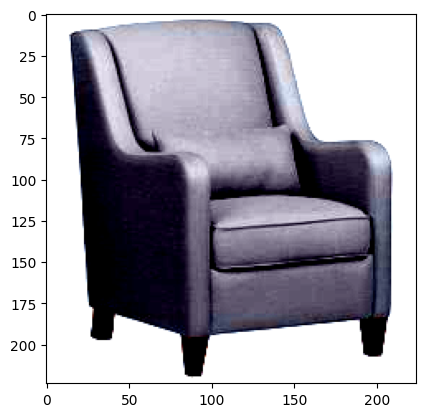

In [34]:
plt.imshow(x['pixel_values'][0][8].permute(1,2,0).numpy())

## Model Architecture

In [35]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 38.5 MB/s eta 0:00:00


In [36]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from pyexpat import features
import copy
import math
from sys import prefix
import numpy as np
# import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import os
from transformers import CLIPModel, AutoConfig, AutoModel
from dataclasses import dataclass

In [37]:
class CLIPClassifier(nn.Module):

    def __init__(self, args):
        super().__init__()

        self.num_mapping_layers = args.num_mapping_layers
        self.map_dim = args.map_dim
        self.fusion = args.fusion
        self.num_pre_output_layers = args.num_pre_output_layers
        self.lr = args.lr
        self.weight_decay = args.weight_decay
        self.weight_image_loss = args.weight_image_loss
        self.weight_text_loss = args.weight_text_loss

        self.clip = CLIPModel.from_pretrained(args.clip_pretrained_model)

        ## Encoder Layers
        self.image_encoder = copy.deepcopy(self.clip.vision_model)
        self.text_encoder = copy.deepcopy(self.clip.text_model)

        ## Projection Layers
        image_map_layers = [nn.Linear(self.image_encoder.config.hidden_size, self.map_dim), nn.Dropout(p=args.drop_probs[0])]
        text_map_layers = [nn.Linear(self.text_encoder.config.hidden_size, self.map_dim), nn.Dropout(p=args.drop_probs[0])]
        for _ in range(1, self.num_mapping_layers):
            image_map_layers.extend([nn.ReLU(), nn.Linear(self.map_dim, self.map_dim), nn.Dropout(p=args.drop_probs[0])])
            text_map_layers.extend([nn.ReLU(), nn.Linear(self.map_dim, self.map_dim), nn.Dropout(p=args.drop_probs[0])])

        self.image_map = nn.Sequential(*image_map_layers)
        self.text_map = nn.Sequential(*text_map_layers)

        ## Pre Output Layers
        if args.fusion in ['align', 'align_shuffle']:
            pre_output_input_dim = self.map_dim
        elif args.fusion == 'concat':
            pre_output_input_dim = self.map_dim*2
        elif args.fusion.startswith('cross'):
            pre_output_input_dim = self.map_dim**2
        elif args.fusion == 'align_concat':
            pre_output_input_dim = self.map_dim*3
        elif args.fusion == 'attention_m':
            self.gen_query = nn.Linear(self.map_dim, self.map_dim//4)
            self.gen_key = nn.Linear(self.map_dim, self.map_dim//4)
            self.soft = nn.Softmax(dim=1)
            pre_output_input_dim = self.map_dim*2

        pre_output_layers = [nn.Dropout(p=args.drop_probs[1])]
        output_input_dim = pre_output_input_dim
        if self.num_pre_output_layers >= 1: # first pre-output layer
            pre_output_layers.extend([nn.Linear(pre_output_input_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args.drop_probs[2])])
            output_input_dim = self.map_dim
        for _ in range(1, self.num_pre_output_layers): # next pre-output layers
            pre_output_layers.extend([nn.Linear(self.map_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args.drop_probs[2])])

        self.pre_output = nn.Sequential(*pre_output_layers)

        ## Output Layer
        self.output = nn.Linear(output_input_dim, args.num_class)

        if args.freeze_image_encoder:
            for _, p in self.image_encoder.named_parameters():
                p.requires_grad_(False)

        if args.freeze_text_encoder:
            for _, p in self.text_encoder.named_parameters():
                p.requires_grad_(False)

        del self.clip

    def forward(self, batch):
        image_features = self.image_encoder(pixel_values=batch['pixel_values'][0]).pooler_output
        image_features = self.image_map(image_features)

        text_features = self.text_encoder(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).pooler_output
        text_features = self.text_map(text_features)

        image_features = F.normalize(image_features, p=2, dim=1) # [batch_size, d]
        text_features = F.normalize(text_features, p=2, dim=1) # [batch_size, d]

        if self.fusion in ['align', 'align_shuffle']:
            features = torch.mul(image_features, text_features)  # [batch_size, d]

        elif self.fusion == 'concat':
            features = torch.cat([image_features, text_features], dim=1)  # [batch_size, 2*d]

        elif self.fusion.startswith('cross'):
            features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1)) # [batch_size, d, d]
            if self.fusion == 'cross_nd':
                mask = torch.eye(self.map_dim).repeat(features.shape[0], 1, 1).bool()
                features[mask] = torch.zeros(features.shape[0]*self.map_dim, device=features.device)
                del mask
            features = features.reshape(features.shape[0], -1)  # [batch_size, d*d]

        elif self.fusion == 'align_concat':
            features = torch.cat([torch.mul(image_features, text_features), image_features, text_features], dim=1)  # [batch_size, 3*d]

        elif self.fusion == 'attention_m':
            q1 = F.relu(self.gen_query(image_features))
            k1 = F.relu(self.gen_key(image_features))
            q2 = F.relu(self.gen_query(text_features))
            k2 = F.relu(self.gen_key(text_features))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = image_features * prob_1[:, None]
            wtd_i2 = text_features * prob_2[:, None]
            features = torch.cat((wtd_i1,wtd_i2), 1) # [batch_size, 2*d]
        else:
                raise ValueError()

        features = self.pre_output(features)
        logits = self.output(features)

        # probs = F.softmax(logits, dim=1)

        return logits

In [38]:
model = CLIPClassifier(args)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [39]:
model

CLIPClassifier(
  (image_encoder): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
    

In [40]:
trainable_layers = [(name, param) for name, param in model.named_parameters() if param.requires_grad]

# To print trainable layers
for name, param in trainable_layers:
    print(f"Layer: {name}, Size: {param.size()}")

Layer: image_map.0.weight, Size: torch.Size([256, 768])
Layer: image_map.0.bias, Size: torch.Size([256])
Layer: text_map.0.weight, Size: torch.Size([256, 512])
Layer: text_map.0.bias, Size: torch.Size([256])
Layer: pre_output.1.weight, Size: torch.Size([256, 65536])
Layer: pre_output.1.bias, Size: torch.Size([256])
Layer: pre_output.4.weight, Size: torch.Size([256, 256])
Layer: pre_output.4.bias, Size: torch.Size([256])
Layer: pre_output.7.weight, Size: torch.Size([256, 256])
Layer: pre_output.7.bias, Size: torch.Size([256])
Layer: output.weight, Size: torch.Size([34, 256])
Layer: output.bias, Size: torch.Size([34])


## Train and Validation Step

In [41]:
def train_and_validate(model, train_dataloader, val_dataloader, epochs, device, loss_fn,optimizer, scheduler=None, print_every=100):
    """
    Train and validate the model.

    :param model: The CLIPClassifier model.
    :param train_dataloader: DataLoader for the training dataset.
    :param val_dataloader: DataLoader for the validation dataset.
    :param epochs: Number of training epochs.
    :param device: The device to use for training (e.g., 'cuda' or 'cpu').
    :param loss_fn: Loss function for training.
    :param optimizer: Optimizer for model training.
    :param scheduler: Learning rate scheduler (optional).
    :param print_every: How frequently to print training status.
    """

    model.to(device)

    # Trackers for loss and accuracy
    best_val_accuracy = 0.0

    # Loop over epochs
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss = 0.0
        train_preds = []
        train_labels = []

        # Progress bar for training
        train_progress = tqdm(train_dataloader, desc='Training', leave=False)

        for batch_idx, batch in enumerate(train_progress):
            # Move batch to device
            pixel_values = batch['pixel_values'][0].to(device)
            pixel_values = [pixel_values]
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            preds = model({
                'pixel_values': pixel_values,
                'input_ids': input_ids,
                'attention_mask': attention_mask
            })

            # Compute loss
            loss = loss_fn(preds, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            # Track loss and accuracy
            total_train_loss += loss.item()
            train_preds.extend(torch.argmax(preds,dim=1).detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

            # Print progress
            if batch_idx % print_every == 0:
                avg_loss = total_train_loss / (batch_idx + 1)
                print(f"Batch {batch_idx}, Training Loss: {avg_loss:.4f}")

        # Calculate train accuracy
        train_accuracy = accuracy_score(train_labels, train_preds)
        print(f"Epoch {epoch + 1} Training Loss: {total_train_loss / len(train_dataloader):.4f}")
        print(f"Epoch {epoch + 1} Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            val_progress = tqdm(val_dataloader, desc='Validating', leave=False)

            for batch in val_progress:
                # Move batch to device
                pixel_values = batch['pixel_values'][0].to(device)
                pixel_values = [pixel_values]
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                preds = model({
                    'pixel_values': pixel_values,
                    'input_ids': input_ids,
                    'attention_mask': attention_mask
                })

                # Compute loss
                loss = loss_fn(preds, labels)
                total_val_loss += loss.item()

                # Track predictions and labels
                val_preds.extend(torch.argmax(preds,dim=1).detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch + 1} Validation Loss: {total_val_loss / len(val_dataloader):.4f}")
        print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best model saved with validation accuracy: {best_val_accuracy:.4f}")

    print(f"Training complete. Best Validation Accuracy: {best_val_accuracy:.4f}")


In [42]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
scheduler = None

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=10,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)



Epoch 1/10


Training:   0%|          | 2/548 [00:03<14:41,  1.61s/it]

Batch 0, Training Loss: 3.5243


Training:  19%|█▊        | 102/548 [00:26<01:41,  4.38it/s]

Batch 100, Training Loss: 1.9237


Training:  37%|███▋      | 201/548 [00:53<01:34,  3.68it/s]

Batch 200, Training Loss: 1.5505


Training:  55%|█████▌    | 302/548 [01:18<00:40,  6.11it/s]

Batch 300, Training Loss: 1.3839


Training:  73%|███████▎  | 401/548 [01:36<00:21,  6.80it/s]

Batch 400, Training Loss: 1.2660


Training:  92%|█████████▏| 502/548 [01:54<00:07,  6.17it/s]

Batch 500, Training Loss: 1.2067


Epoch 1 Training Loss: 1.1718
Epoch 1 Training Accuracy: 0.6225


Epoch 1 Validation Loss: 0.7189
Epoch 1 Validation Accuracy: 0.7540
Best model saved with validation accuracy: 0.7540

Epoch 2/10


Training:   0%|          | 2/548 [00:01<04:06,  2.21it/s]

Batch 0, Training Loss: 0.8179


Training:  19%|█▊        | 102/548 [00:18<01:07,  6.60it/s]

Batch 100, Training Loss: 0.7786


Training:  37%|███▋      | 202/548 [00:36<00:53,  6.46it/s]

Batch 200, Training Loss: 0.7805


Training:  55%|█████▌    | 302/548 [00:54<00:36,  6.70it/s]

Batch 300, Training Loss: 0.7712


Training:  73%|███████▎  | 402/548 [01:11<00:21,  6.72it/s]

Batch 400, Training Loss: 0.7573


Training:  92%|█████████▏| 502/548 [01:30<00:06,  6.70it/s]

Batch 500, Training Loss: 0.7437


Epoch 2 Training Loss: 0.7467
Epoch 2 Training Accuracy: 0.7430


Epoch 2 Validation Loss: 0.6096
Epoch 2 Validation Accuracy: 0.7673
Best model saved with validation accuracy: 0.7673

Epoch 3/10


Training:   0%|          | 2/548 [00:00<03:21,  2.71it/s]

Batch 0, Training Loss: 0.5458


Training:  19%|█▊        | 102/548 [00:18<01:10,  6.29it/s]

Batch 100, Training Loss: 0.6257


Training:  37%|███▋      | 202/548 [00:35<00:48,  7.14it/s]

Batch 200, Training Loss: 0.6488


Training:  55%|█████▌    | 302/548 [00:52<00:38,  6.47it/s]

Batch 300, Training Loss: 0.6642


Training:  73%|███████▎  | 402/548 [01:10<00:22,  6.44it/s]

Batch 400, Training Loss: 0.6802


Training:  92%|█████████▏| 502/548 [01:28<00:06,  6.61it/s]

Batch 500, Training Loss: 0.6866


Epoch 3 Training Loss: 0.6838
Epoch 3 Training Accuracy: 0.7597


Epoch 3 Validation Loss: 0.5739
Epoch 3 Validation Accuracy: 0.7838
Best model saved with validation accuracy: 0.7838

Epoch 4/10


Training:   0%|          | 2/548 [00:00<03:43,  2.44it/s]

Batch 0, Training Loss: 0.8945


Training:  19%|█▊        | 102/548 [00:18<01:08,  6.53it/s]

Batch 100, Training Loss: 0.6732


Training:  37%|███▋      | 202/548 [00:35<00:50,  6.83it/s]

Batch 200, Training Loss: 0.6797


Training:  55%|█████▌    | 302/548 [00:53<00:40,  6.02it/s]

Batch 300, Training Loss: 0.6593


Training:  73%|███████▎  | 401/548 [01:10<00:29,  4.95it/s]

Batch 400, Training Loss: 0.6503


Training:  92%|█████████▏| 502/548 [01:28<00:09,  4.91it/s]

Batch 500, Training Loss: 0.6484


Epoch 4 Training Loss: 0.6526
Epoch 4 Training Accuracy: 0.7710


Epoch 4 Validation Loss: 0.6569
Epoch 4 Validation Accuracy: 0.7798

Epoch 5/10


Training:   0%|          | 2/548 [00:00<03:06,  2.92it/s]

Batch 0, Training Loss: 0.2922


Training:  18%|█▊        | 101/548 [00:19<01:41,  4.41it/s]

Batch 100, Training Loss: 0.6201


Training:  37%|███▋      | 201/548 [00:37<01:22,  4.22it/s]

Batch 200, Training Loss: 0.6301


Training:  55%|█████▌    | 302/548 [00:56<00:41,  5.87it/s]

Batch 300, Training Loss: 0.6394


Training:  73%|███████▎  | 402/548 [01:14<00:24,  6.08it/s]

Batch 400, Training Loss: 0.6274


Training:  92%|█████████▏| 502/548 [01:32<00:07,  6.30it/s]

Batch 500, Training Loss: 0.6313


Epoch 5 Training Loss: 0.6340
Epoch 5 Training Accuracy: 0.7825


Epoch 5 Validation Loss: 0.5567
Epoch 5 Validation Accuracy: 0.8078
Best model saved with validation accuracy: 0.8078

Epoch 6/10


Training:   0%|          | 2/548 [00:00<03:27,  2.63it/s]

Batch 0, Training Loss: 0.5928


Training:  19%|█▊        | 102/548 [00:19<01:12,  6.18it/s]

Batch 100, Training Loss: 0.6180


Training:  37%|███▋      | 202/548 [00:37<01:07,  5.11it/s]

Batch 200, Training Loss: 0.5803


Training:  55%|█████▌    | 302/548 [00:56<00:57,  4.29it/s]

Batch 300, Training Loss: 0.5860


Training:  73%|███████▎  | 402/548 [01:15<00:26,  5.51it/s]

Batch 400, Training Loss: 0.6019


Training:  92%|█████████▏| 502/548 [01:33<00:07,  6.46it/s]

Batch 500, Training Loss: 0.6089


Epoch 6 Training Loss: 0.6108
Epoch 6 Training Accuracy: 0.7860


Epoch 6 Validation Loss: 0.6066
Epoch 6 Validation Accuracy: 0.8022

Epoch 7/10


Training:   0%|          | 2/548 [00:00<03:29,  2.61it/s]

Batch 0, Training Loss: 0.9334


Training:  18%|█▊        | 101/548 [00:18<01:12,  6.14it/s]

Batch 100, Training Loss: 0.5700


Training:  37%|███▋      | 202/548 [00:36<00:53,  6.43it/s]

Batch 200, Training Loss: 0.5637


Training:  55%|█████▍    | 301/548 [00:54<00:38,  6.44it/s]

Batch 300, Training Loss: 0.5869


Training:  73%|███████▎  | 402/548 [01:13<00:22,  6.46it/s]

Batch 400, Training Loss: 0.5882


Training:  91%|█████████▏| 501/548 [01:31<00:07,  5.96it/s]

Batch 500, Training Loss: 0.5959


Epoch 7 Training Loss: 0.6072
Epoch 7 Training Accuracy: 0.7878


Epoch 7 Validation Loss: 0.6327
Epoch 7 Validation Accuracy: 0.7846

Epoch 8/10


Training:   0%|          | 2/548 [00:00<02:58,  3.06it/s]

Batch 0, Training Loss: 0.6409


Training:  19%|█▊        | 102/548 [00:19<01:39,  4.50it/s]

Batch 100, Training Loss: 0.5719


Training:  37%|███▋      | 201/548 [00:38<01:15,  4.58it/s]

Batch 200, Training Loss: 0.5809


Training:  55%|█████▌    | 302/548 [00:58<00:46,  5.29it/s]

Batch 300, Training Loss: 0.5609


Training:  73%|███████▎  | 402/548 [01:16<00:24,  6.02it/s]

Batch 400, Training Loss: 0.5813


Training:  92%|█████████▏| 502/548 [01:34<00:06,  6.72it/s]

Batch 500, Training Loss: 0.6056


Epoch 8 Training Loss: 0.5997
Epoch 8 Training Accuracy: 0.7902


Epoch 8 Validation Loss: 0.5737
Epoch 8 Validation Accuracy: 0.8166
Best model saved with validation accuracy: 0.8166

Epoch 9/10


Training:   0%|          | 2/548 [00:01<04:47,  1.90it/s]

Batch 0, Training Loss: 0.3475


Training:  18%|█▊        | 101/548 [00:20<01:50,  4.05it/s]

Batch 100, Training Loss: 0.5753


Training:  37%|███▋      | 202/548 [00:40<01:26,  4.01it/s]

Batch 200, Training Loss: 0.5539


Training:  55%|█████▌    | 302/548 [00:58<00:36,  6.66it/s]

Batch 300, Training Loss: 0.5439


Training:  73%|███████▎  | 402/548 [01:19<00:23,  6.31it/s]

Batch 400, Training Loss: 0.5519


Training:  92%|█████████▏| 502/548 [01:38<00:07,  6.42it/s]

Batch 500, Training Loss: 0.5577


Epoch 9 Training Loss: 0.5710
Epoch 9 Training Accuracy: 0.7971


Epoch 9 Validation Loss: 0.6288
Epoch 9 Validation Accuracy: 0.7875

Epoch 10/10


Training:   0%|          | 2/548 [00:00<03:03,  2.98it/s]

Batch 0, Training Loss: 0.7530


Training:  18%|█▊        | 101/548 [00:19<01:23,  5.34it/s]

Batch 100, Training Loss: 0.5575


Training:  37%|███▋      | 202/548 [00:40<01:29,  3.89it/s]

Batch 200, Training Loss: 0.5787


Training:  55%|█████▍    | 301/548 [00:58<00:39,  6.19it/s]

Batch 300, Training Loss: 0.5563


Training:  73%|███████▎  | 401/548 [01:17<00:22,  6.46it/s]

Batch 400, Training Loss: 0.5539


Training:  92%|█████████▏| 502/548 [01:35<00:06,  6.59it/s]

Batch 500, Training Loss: 0.5592


Epoch 10 Training Loss: 0.5605
Epoch 10 Training Accuracy: 0.8005


Epoch 10 Validation Loss: 0.5844
Epoch 10 Validation Accuracy: 0.8152
Training complete. Best Validation Accuracy: 0.8166


In [63]:

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=50,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)


Epoch 1/50


Training:   0%|          | 2/548 [00:00<03:19,  2.73it/s]

Batch 0, Training Loss: 3.5115


Training:  18%|█▊        | 101/548 [00:17<01:06,  6.75it/s]

Batch 100, Training Loss: 3.4851


Training:  37%|███▋      | 202/548 [00:37<01:00,  5.68it/s]

Batch 200, Training Loss: 3.4850


KeyboardInterrupt: 

In [43]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=5,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)



Epoch 1/5


Training:   0%|          | 1/548 [00:05<51:07,  5.61s/it]

Batch 0, Training Loss: 3.5077


Training:  19%|█▊        | 102/548 [00:28<01:09,  6.42it/s]

Batch 100, Training Loss: 3.4662


Training:  37%|███▋      | 201/548 [00:47<00:56,  6.19it/s]

Batch 200, Training Loss: 3.4646


Training:  55%|█████▍    | 301/548 [01:06<00:53,  4.60it/s]

Batch 300, Training Loss: 3.4646


Training:  73%|███████▎  | 402/548 [01:25<00:28,  5.18it/s]

Batch 400, Training Loss: 3.4641


Training:  92%|█████████▏| 502/548 [01:45<00:07,  6.53it/s]

Batch 500, Training Loss: 3.4638


Epoch 1 Training Loss: 3.4635
Epoch 1 Training Accuracy: 0.1013


Epoch 1 Validation Loss: 3.4624
Epoch 1 Validation Accuracy: 0.0780
Best model saved with validation accuracy: 0.0780

Epoch 2/5


Training:   0%|          | 2/548 [00:00<03:44,  2.44it/s]

Batch 0, Training Loss: 3.4634


Training:  19%|█▊        | 102/548 [00:18<01:27,  5.11it/s]

Batch 100, Training Loss: 3.4681


Training:  37%|███▋      | 202/548 [00:35<01:09,  4.99it/s]

Batch 200, Training Loss: 3.4636


Training:  55%|█████▍    | 301/548 [00:54<00:58,  4.20it/s]

Batch 300, Training Loss: 3.4630


Training:  73%|███████▎  | 401/548 [01:11<00:32,  4.48it/s]

Batch 400, Training Loss: 3.4635


Training:  91%|█████████▏| 501/548 [01:28<00:11,  4.09it/s]

Batch 500, Training Loss: 3.4634


Epoch 2 Training Loss: 3.4634
Epoch 2 Training Accuracy: 0.1009


Epoch 2 Validation Loss: 3.4624
Epoch 2 Validation Accuracy: 0.0780

Epoch 3/5


Training:   0%|          | 1/548 [00:00<07:04,  1.29it/s]

Batch 0, Training Loss: 3.4674


Training:  19%|█▊        | 102/548 [00:19<01:34,  4.70it/s]

Batch 100, Training Loss: 3.4627


Training:  37%|███▋      | 202/548 [00:43<00:50,  6.84it/s]

Batch 200, Training Loss: 3.4625


Training:  55%|█████▌    | 302/548 [01:02<00:36,  6.71it/s]

Batch 300, Training Loss: 3.4627


Training:  73%|███████▎  | 402/548 [01:19<00:21,  6.88it/s]

Batch 400, Training Loss: 3.4633


Training:  92%|█████████▏| 502/548 [01:36<00:06,  7.31it/s]

Batch 500, Training Loss: 3.4631


Epoch 3 Training Loss: 3.4633
Epoch 3 Training Accuracy: 0.1022


Epoch 3 Validation Loss: 3.4624
Epoch 3 Validation Accuracy: 0.0780

Epoch 4/5


Training:   0%|          | 2/548 [00:00<03:36,  2.53it/s]

Batch 0, Training Loss: 3.4612


Training:  19%|█▊        | 102/548 [00:18<01:08,  6.51it/s]

Batch 100, Training Loss: 3.4642


Training:  37%|███▋      | 202/548 [00:36<00:52,  6.63it/s]

Batch 200, Training Loss: 3.4652


Training:  55%|█████▌    | 302/548 [00:53<00:44,  5.47it/s]

Batch 300, Training Loss: 3.4646


Training:  73%|███████▎  | 402/548 [01:11<00:29,  5.03it/s]

Batch 400, Training Loss: 3.4637


Training:  91%|█████████▏| 501/548 [01:28<00:08,  5.53it/s]

Batch 500, Training Loss: 3.4631


Epoch 4 Training Loss: 3.4632
Epoch 4 Training Accuracy: 0.0992


Epoch 4 Validation Loss: 3.4624
Epoch 4 Validation Accuracy: 0.0780

Epoch 5/5


Training:   0%|          | 2/548 [00:00<02:56,  3.09it/s]

Batch 0, Training Loss: 3.4511


Training:  19%|█▊        | 102/548 [00:18<01:53,  3.93it/s]

Batch 100, Training Loss: 3.4638


KeyboardInterrupt: 

In [ ]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=5,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)



Epoch 1/5


Training:   0%|          | 1/548 [00:03<34:56,  3.83s/it]

Batch 0, Training Loss: 3.5368


Training:  18%|█▊        | 101/548 [00:41<03:39,  2.04it/s]

Batch 100, Training Loss: 3.4830


Training:  37%|███▋      | 201/548 [01:12<01:10,  4.93it/s]

Batch 200, Training Loss: 3.4845


Training:  55%|█████▍    | 301/548 [01:38<01:03,  3.91it/s]

Batch 300, Training Loss: 3.4833


Training:  73%|███████▎  | 402/548 [02:02<00:28,  5.06it/s]

Batch 400, Training Loss: 3.4823


Training:  91%|█████████▏| 501/548 [02:30<00:14,  3.19it/s]

Batch 500, Training Loss: 3.4822


Epoch 1 Training Loss: 3.4824
Epoch 1 Training Accuracy: 0.1233


Epoch 1 Validation Loss: 3.4811
Epoch 1 Validation Accuracy: 0.1198
Best model saved with validation accuracy: 0.1198

Epoch 2/5


Training:   0%|          | 2/548 [00:01<05:01,  1.81it/s]

Batch 0, Training Loss: 3.5184


Training:  18%|█▊        | 101/548 [00:24<01:57,  3.80it/s]

Batch 100, Training Loss: 3.4828


Training:  37%|███▋      | 202/548 [00:48<01:06,  5.19it/s]

Batch 200, Training Loss: 3.4826


Training:  55%|█████▌    | 302/548 [01:11<00:46,  5.23it/s]

Batch 300, Training Loss: 3.4822


Training:  59%|█████▉    | 322/548 [01:16<01:14,  3.04it/s]

In [ ]:
# Assuming you have train_dataloader and val_dataloader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
            {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
            ]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=5,
    device=device,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)



Epoch 1/5


Training:   0%|          | 2/1096 [00:00<07:44,  2.36it/s]

Batch 0, Training Loss: 3.5470


Training:   9%|▉         | 102/1096 [00:12<01:30, 11.02it/s]

Batch 100, Training Loss: 3.4962


Training:  18%|█▊        | 202/1096 [00:21<01:29, 10.04it/s]

Batch 200, Training Loss: 3.4930


Training:  28%|██▊       | 303/1096 [00:32<01:11, 11.15it/s]

Batch 300, Training Loss: 3.4927


Training:  37%|███▋      | 402/1096 [00:46<00:59, 11.68it/s]

Batch 400, Training Loss: 3.4929


Training:  46%|████▌     | 502/1096 [00:55<01:12,  8.23it/s]

Batch 500, Training Loss: 3.4923


Training:  55%|█████▍    | 602/1096 [01:06<00:42, 11.61it/s]

Batch 600, Training Loss: 3.4930


Training:  64%|██████▍   | 702/1096 [01:17<00:55,  7.13it/s]

Batch 700, Training Loss: 3.4933


Training:  73%|███████▎  | 802/1096 [01:26<00:25, 11.54it/s]

Batch 800, Training Loss: 3.4927


Training:  82%|████████▏ | 902/1096 [01:37<00:18, 10.77it/s]

Batch 900, Training Loss: 3.4928


Training:  91%|█████████▏| 1002/1096 [01:47<00:15,  6.20it/s]

Batch 1000, Training Loss: 3.4929


Epoch 1 Training Loss: 3.4926
Epoch 1 Training Accuracy: 0.0859


Epoch 1 Validation Loss: 3.4911
Epoch 1 Validation Accuracy: 0.1198
Best model saved with validation accuracy: 0.1198

Epoch 2/5


Training:   0%|          | 2/1096 [00:01<11:54,  1.53it/s]

Batch 0, Training Loss: 3.4675


Training:   9%|▉         | 102/1096 [00:19<01:32, 10.74it/s]

Batch 100, Training Loss: 3.4922


Training:  19%|█▊        | 203/1096 [00:32<01:21, 10.94it/s]

Batch 200, Training Loss: 3.4912


Training:  27%|██▋       | 301/1096 [00:40<01:11, 11.09it/s]

Batch 300, Training Loss: 3.4917


Training:  37%|███▋      | 402/1096 [00:53<01:02, 11.14it/s]

Batch 400, Training Loss: 3.4929


Training:  46%|████▌     | 502/1096 [01:04<01:29,  6.63it/s]

Batch 500, Training Loss: 3.4925


Training:  55%|█████▍    | 602/1096 [01:12<00:44, 11.15it/s]

Batch 600, Training Loss: 3.4920


Training:  64%|██████▍   | 702/1096 [01:24<00:33, 11.63it/s]

Batch 700, Training Loss: 3.4922


Training:  73%|███████▎  | 802/1096 [01:34<00:41,  7.16it/s]

Batch 800, Training Loss: 3.4921


Training:  82%|████████▏ | 903/1096 [01:46<00:17, 10.82it/s]

Batch 900, Training Loss: 3.4919


Training:  91%|█████████▏| 1002/1096 [01:57<00:08, 11.48it/s]

Batch 1000, Training Loss: 3.4924


Epoch 2 Training Loss: 3.4924
Epoch 2 Training Accuracy: 0.0854


Epoch 2 Validation Loss: 3.4911
Epoch 2 Validation Accuracy: 0.1198

Epoch 3/5


Training:   0%|          | 3/1096 [00:00<04:16,  4.27it/s]

Batch 0, Training Loss: 3.4742


Training:   9%|▉         | 103/1096 [00:14<01:26, 11.43it/s]

Batch 100, Training Loss: 3.4930


Training:  18%|█▊        | 202/1096 [00:25<02:12,  6.74it/s]

Batch 200, Training Loss: 3.4953


Training:  28%|██▊       | 302/1096 [00:34<01:13, 10.82it/s]

Batch 300, Training Loss: 3.4940


Training:  37%|███▋      | 402/1096 [00:46<00:59, 11.63it/s]

Batch 400, Training Loss: 3.4931


Training:  46%|████▌     | 502/1096 [00:56<01:36,  6.17it/s]

Batch 500, Training Loss: 3.4934


Training:  55%|█████▌    | 603/1096 [01:06<00:42, 11.50it/s]

Batch 600, Training Loss: 3.4932


Training:  64%|██████▍   | 703/1096 [01:18<00:36, 10.89it/s]

Batch 700, Training Loss: 3.4924


Training:  73%|███████▎  | 802/1096 [01:27<00:41,  7.11it/s]

Batch 800, Training Loss: 3.4926


Training:  82%|████████▏ | 903/1096 [01:38<00:17, 11.00it/s]

Batch 900, Training Loss: 3.4928


Training:  91%|█████████▏| 1002/1096 [01:50<00:08, 10.87it/s]

Batch 1000, Training Loss: 3.4925


Epoch 3 Training Loss: 3.4923
Epoch 3 Training Accuracy: 0.0862


Epoch 3 Validation Loss: 3.4911
Epoch 3 Validation Accuracy: 0.1198

Epoch 4/5


Training:   0%|          | 3/1096 [00:00<04:24,  4.13it/s]

Batch 0, Training Loss: 3.5201


Training:   9%|▉         | 102/1096 [00:13<01:25, 11.67it/s]

Batch 100, Training Loss: 3.4924


Training:  18%|█▊        | 202/1096 [00:21<01:16, 11.68it/s]

Batch 200, Training Loss: 3.4938


Training:  28%|██▊       | 302/1096 [00:33<01:13, 10.75it/s]

Batch 300, Training Loss: 3.4922


Training:  37%|███▋      | 401/1096 [00:46<01:47,  6.49it/s]

Batch 400, Training Loss: 3.4914


Training:  46%|████▌     | 502/1096 [01:00<01:31,  6.51it/s]

Batch 500, Training Loss: 3.4924


Training:  55%|█████▌    | 603/1096 [01:10<00:44, 11.08it/s]

Batch 600, Training Loss: 3.4928


Training:  64%|██████▍   | 703/1096 [01:24<00:36, 10.90it/s]

Batch 700, Training Loss: 3.4929


Training:  73%|███████▎  | 802/1096 [01:35<00:43,  6.71it/s]

Batch 800, Training Loss: 3.4932


Training:  82%|████████▏ | 903/1096 [01:44<00:16, 11.69it/s]

Batch 900, Training Loss: 3.4926


Training:  91%|█████████▏| 1002/1096 [01:56<00:08, 11.32it/s]

Batch 1000, Training Loss: 3.4928


Epoch 4 Training Loss: 3.4926
Epoch 4 Training Accuracy: 0.0893


Epoch 4 Validation Loss: 3.4911
Epoch 4 Validation Accuracy: 0.1198

Epoch 5/5


Training:   0%|          | 3/1096 [00:00<04:36,  3.95it/s]

Batch 0, Training Loss: 3.4697


Training:   9%|▉         | 103/1096 [00:12<01:57,  8.44it/s]

Batch 100, Training Loss: 3.4934


Training:  18%|█▊        | 202/1096 [00:21<02:01,  7.35it/s]

Batch 200, Training Loss: 3.4913


KeyboardInterrupt: 

## Archive

In [ ]:
import torch
import numpy as np

# Define batch size and dimensions
batch_size = 4
image_size = (3, 224, 224)  # Typical image size for models like CLIP (3 channels, 224x224 pixels)
text_sequence_length = 77  # CLIP typically uses a sequence length of 77

# Random input for images (simulating pixel values)
random_images = torch.rand(batch_size, *image_size)  # [batch_size, channels, height, width]

# Random input for text (simulating token ids and attention mask)
random_input_ids = torch.randint(0, 10000, (batch_size, text_sequence_length))  # Random token IDs
random_attention_mask = torch.ones(batch_size, text_sequence_length)  # Attention mask (all ones for simplicity)

# Create the batch input to match the model's expected input format
batch = {
    'pixel_values': [random_images],  # Model expects pixel_values as a list
    'input_ids': random_input_ids,
    'attention_mask': random_attention_mask
}

# Pass this batch into the model's forward method
result = model(batch)
